# This notebook shows an example of how to extract embeddings from one 5 channeled image.
 
## Attribution-NonCommercial-ShareAlike 4.0 International

In [1]:
!pip install --upgrade tf_slim

#from google.colab import drive
import glob,sys
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL.Image

import tensorflow.compat.v1 as tf
import tf_slim as slim

# Get slim inception code from tf_slim.nets import inception # throws error no attribute 'inception_v4_arg_scope'
if not os.path.exists('models/research/slim'):
  print('not')
  !git clone https://github.com/tensorflow/models/
old_cwd = os.getcwd()
os.chdir('models/research/slim')
sys.path.append('models/research/slim/')
from nets import inception
os.chdir(old_cwd)

# Download inceptionv4 checkpoint
if not os.path.exists('inception_v4_2016_09_09.tar.gz'):
  !wget http://download.tensorflow.org/models/inception_v4_2016_09_09.tar.gz
  !tar -xvzf inception_v4_2016_09_09.tar.gz
else:
  print('File already downloaded')

Requirement already up-to-date: tf_slim in /home/bianca/anaconda3/lib/python3.7/site-packages (1.1.0)
File already downloaded


In [2]:
DATA_DIR = '~/Embeddings/'  # NOTE - You need to set this to the location of the data.
IMAGES_DIR = os.path.join(DATA_DIR, 'imgs/fullres_8bit_png_bbbc025')
RANDOM_PROJECTION_CKPT = os.path.join(DATA_DIR, 'random_projection/random_projection.ckpt')
INCEPTION_V4_CKPT = 'inception_v4.ckpt'  # This is downloaded in the installs.

In [3]:
#@title Helper functions
def load_image(file_path):
  with PIL.Image.open(file_path) as im:
    im = np.asarray(im)
    return im

def build_inceptionv4_rand64_tower(inputs, is_training=False):
  """Builds an inceptionv4 rand64 tower starting from image tensor.

  The tower consists of an Inception v4 base, and 1 fully connected layer
  reducing output dim to 64, and a normalization layer. Loss is not included.

  Args:
    inputs: An input dictionary mapping key to a tensor of input images i.e.
      {IMAGE_KEY: 4D tensor of (num, h, w, c)}.
    is_training: (bool) Specifies if it is training phase.

  Returns:
    (tensor) A tensor of embeddings.
    (dict) A dictionary mapping endpoint layer names to activation tensors.
  """
  with slim.arg_scope(inception.inception_v4_arg_scope()):
    _, activations = inception.inception_v4(inputs[IMAGE_KEY],
                                            num_classes=1001,
                                            is_training=is_training)
    net = activations['PreLogitsFlatten']
    with slim.arg_scope([slim.fully_connected], activation_fn=None):
      net = slim.fully_connected(net, 64, scope='fc0')
      activations['fc0'] = net
      net = tf.nn.l2_normalize(net, dim=-1, name='embed_norm')
      net = tf.reshape(net, [-1, 64])
      activations['embed_norm'] = net
  return net, activations

['/home/bianca/Documents/Google/Embeddings/imgs/fullres_8bit_png_bbbc025/Stack0000.png', '/home/bianca/Documents/Google/Embeddings/imgs/fullres_8bit_png_bbbc025/Stack0001.png', '/home/bianca/Documents/Google/Embeddings/imgs/fullres_8bit_png_bbbc025/Stack0002.png', '/home/bianca/Documents/Google/Embeddings/imgs/fullres_8bit_png_bbbc025/Stack0003.png', '/home/bianca/Documents/Google/Embeddings/imgs/fullres_8bit_png_bbbc025/Stack0004.png']
(5, 1080, 1080, 1)


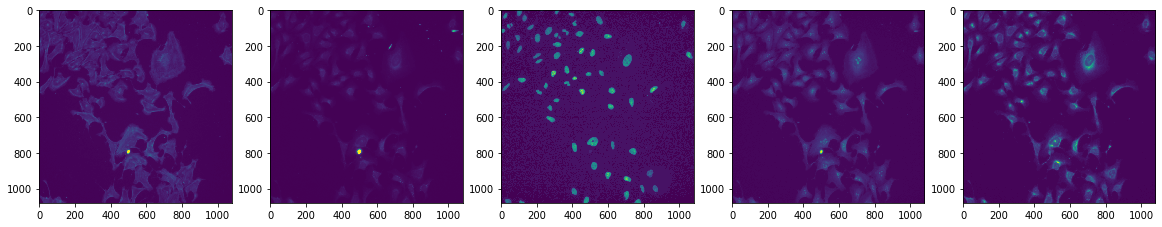

In [4]:
#@title Load Images (sorted by stain names)
image_fnames = sorted(glob.glob('{}/*.png'.format(IMAGES_DIR)))
print(image_fnames)
np_images = []
plt.figure(figsize=(20, 15))
for i, img_fname in enumerate(image_fnames):
  np_images.append(load_image(img_fname))
  plt.subplot(1, len(image_fnames), i+1)
  plt.imshow(np_images[-1])
np_images = np.array(np_images)
np_images = np.expand_dims(np_images, axis=3)
print(np_images.shape)


In [5]:
NUM_STAINS, IMG_HEIGHT, IMG_WIDTH = np_images.shape[0:3]
# The order in which you want the embeddings for each stain. Here embedding for
# img Stack00002.png (DAPI) will come first in the embedding.
STAIN_ORDER = [2,3,4,0,1]
print(NUM_STAINS, IMG_HEIGHT, IMG_WIDTH)


5 1080 1080


In [6]:
#@title Build model and intialize weights. (Run once)

IMAGE_KEY = 'images'
graph = tf.Graph()

with graph.as_default():
  images_ph = tf.placeholder(tf.float32, shape=(None, IMG_HEIGHT, IMG_WIDTH, 1))

  # Resize to 299, 299. This is the input image size for inception.
  images_small = tf.image.resize_images(
      images_ph, [299, 299],
      method=tf.image.ResizeMethod.AREA)
  # Adjust pixel brightness to [0, 1]
  images_small /= 255.0

  # Subtract 0.5 and multiply by 2.0 to keep it within [-1, 1]
  images_small -= 0.5
  images_small *= 2.0
  # Assert image is in [-1, 1]. Add an epsilon on either bound for edge cases.
  epsilon = 0.01
  assert_min = tf.assert_greater_equal(tf.reduce_min(images_small), -(1 + epsilon))
  assert_max = tf.assert_less_equal(tf.reduce_max(images_small), (1 + epsilon))
  with tf.control_dependencies([assert_min, assert_max]):
    images_small = tf.identity(images_small)

  single_stain_images = tf.tile(images_small, [1, 1, 1, 3])
  inputs = {IMAGE_KEY: single_stain_images}
  embed, _ = build_inceptionv4_rand64_tower(inputs, is_training=False)

  assignment_inception_map = {}
  assignment_projection_map = {}

  for v in slim.get_model_variables():
    if v.op.name.startswith('InceptionV4'):
      assignment_inception_map[v.op.name] = v.op.name
    else:
      assignment_projection_map[v.op.name] = v.op.name

  tf.train.init_from_checkpoint(INCEPTION_V4_CKPT, assignment_inception_map)
  tf.train.init_from_checkpoint(RANDOM_PROJECTION_CKPT, assignment_projection_map)

  # We get 1 embedding for each stain. Concatenate the stain embeddings
  # to get 1 embedding for the entire image. This will be of dimension
  # size_of_embedding (64) x num_stains.
  single_stain_embeds = tf.split(embed, NUM_STAINS)
  stain_concat_embed = tf.concat(single_stain_embeds, 1)

  sess = tf.Session(graph=graph)
  saver = tf.train.Saver()
  init_op = tf.global_variables_initializer()
  sess.run(init_op)

def get_ordered_embeddings(input_imgs, images_ph=images_ph,sess=sess):
  stain_embeds, concat_embed = sess.run([single_stain_embeds,
                                         stain_concat_embed],
                                         feed_dict={images_ph: input_imgs})
  ordered_tf_embeds = np.concatenate([stain_embeds[i] for i in STAIN_ORDER],
                                     axis=1)
  return ordered_tf_embeds

Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.Flatten instead.
Instructions for updating:
dim is deprecated, use axis instead


[-0.03725994 -0.04305266 -0.01870182 -0.09225415 -0.03270517 -0.326885
 -0.09732619 -0.0553808  -0.06901019  0.07043048]


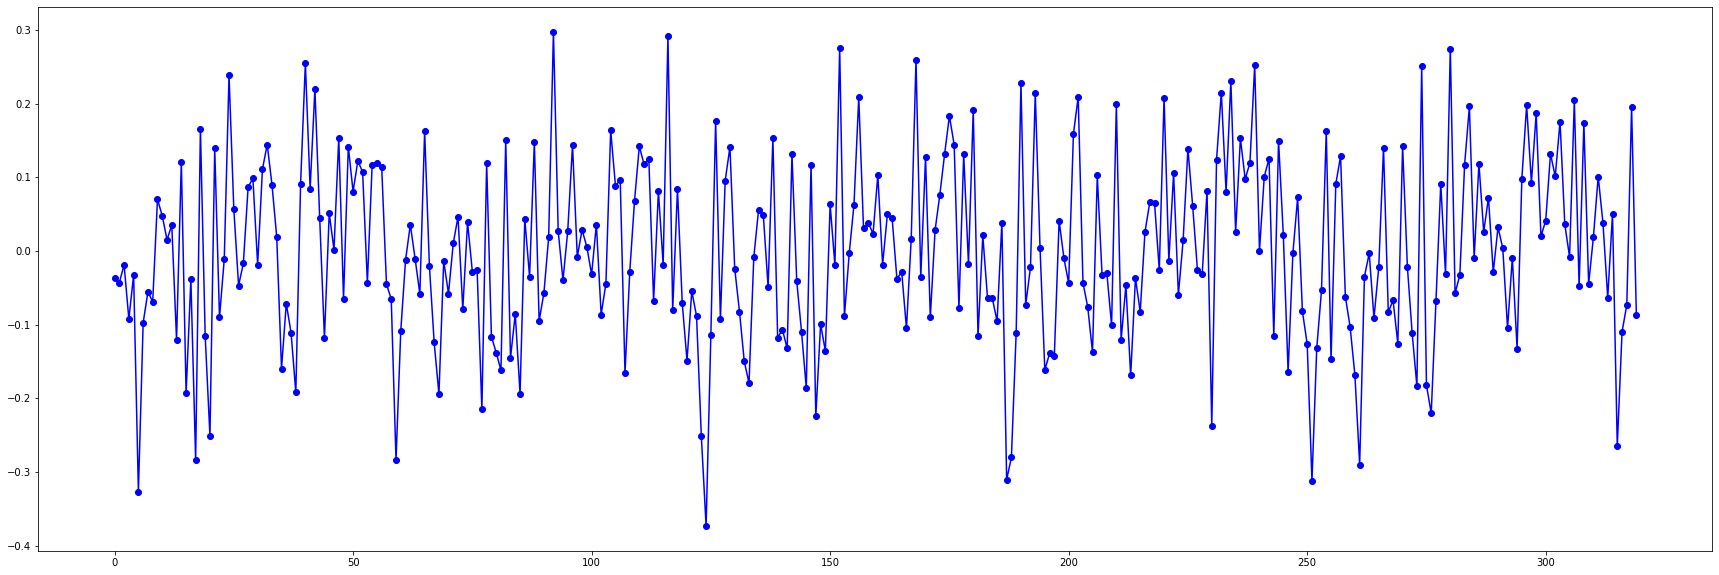

In [7]:
embeds = get_ordered_embeddings(np_images)
print(embeds[0][:10])
plt.figure(figsize=(30,10))
plt.plot(embeds.T, 'b-o')